# Vendor Address Clustering
Input: 38 addresses of vendors active on both Cryptonia and Berlusconi.  
Output: Their wallets (filtered for too big wallets).

In [64]:
#import needed libraries
import tqdm
import pickle
import pandas as pd
import mysql.connector
from decimal import Decimal
from neo4j import GraphDatabase
from datetime import timedelta
import datetime
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# load username and password
df_pw = pd.read_csv("pw.csv", delimiter=",")
# connect to neo4j database
db = GraphDatabase.driver("neo4j://127.0.0.1:7687", auth=(df_pw["name"][0], df_pw["password"][0]))
session = db.session()
# connect to sql database
con = mysql.connector.connect(
    host="localhost",
    user=df_pw["name"][0], 
    passwd=df_pw["password"][0],
    database="DarknetScrape",
)
cursor = con.cursor()

In [3]:
# get vendors active on cryptonia and berlusconi market
cursor.execute("""select a.vendor_id, b.username from (
SELECT vendor_id, count(*) as count
from vendors
group by vendor_id
) as a
JOIN (SELECT vendor_id, username from vendors where market = 'Cryptonia') b
on a.vendor_id = b.vendor_id
where a.count = 2;
""")
results = cursor.fetchall()
df=pd.DataFrame(results, columns=['vendor_id', 'username'])
df.head(3)

,vendor_id,username
0,06fb02d14c74a85e9d140a913a39b295,fungee
1,0950a1f76562be214846bb0d90aaba5f,WackyWestWeed
2,130256b643f1fd56dcc29d20ca39b48e,projeccao


In [4]:
# load addresses of vendors active on cryptonia
j_addresses=pd.read_csv('candidates_final.csv')
j_addresses=j_addresses.drop(columns=['Unnamed: 0'])
j_addresses.head(3)

,Vendor,Address
0,CNSHarmony,34Xo7fKRe9MjYBf3tyJjAFg9qX2kuFuhA1
1,TheHoneymonster,1Ew7BnRn3Q3xkpKMpgc7r5YFrkQXpwXMz7
2,EUCarder,1Nou6Q9qmxbi48m6eSeYy7KHvSSiWFMq5y


In [5]:
# filter for vendors that are active on both markets, not just cryptonia
df=df[df['username'].isin(j_addresses['Vendor'])]
j_addresses = j_addresses[j_addresses["Vendor"].isin(df["username"])]
# add vendor id column to crpytonia vendors
j_addresses_id = pd.merge(j_addresses,df,left_on='Vendor',right_on='username')
j_addresses_id=j_addresses_id[["Vendor","Address","vendor_id"]]
j_addresses_id.head(3)

,Vendor,Address,vendor_id
0,GreenSupreme,bc1qcuxc8fl7eqm8a48sv3n6vgqhc0mtzsswdy4h66,135137a5e88e1fa749c1374f51048773
1,SocialPharma,3DdUb8Tt59tvZacikVt6R9pYWYqzGqgxff,1db74355bd33521d281b3e15cc6dbe21
2,americansteroids,1PWVgJ96YtELbfqEW625JPG16NXsFYU315,26bda6b380be1d4321145f15599f2508


In [6]:
# execute vendor address clustering to get vendor wallets
vendor_wallets = pd.DataFrame()
for i in j_addresses_id.itertuples():
    # initialize wallet & reverse wallet with known address
    wallet = pd.DataFrame(data = [[i.Vendor,i.Address,i.vendor_id]], columns=["Vendor","Address","vendor_id"])
    reverse_wallet = wallet
    print(i.Vendor, " finish: ", datetime.datetime.now())

    while len(reverse_wallet) > 0:
        address = reverse_wallet["Address"][0]
        neo_query = session.run("""
                MATCH (vendor:Address)
                    WHERE vendor.address = '""" + address + """'
                WITH vendor
                MATCH (vendor)-[r:SENDS]->(t:Transaction)
                WITH t
                MATCH (vendor2:Address)-[s:SENDS]->(t)

                RETURN DISTINCT vendor2.address LIMIT 200
                """)
        wallet_temp = set()
        for r in neo_query:
            wallet_temp.add(r[0])
        
        if len(wallet_temp) > 0:
            df_neo4j = pd.DataFrame(wallet_temp)
            df_neo4j["Vendor"] = i.Vendor
            df_neo4j["Address"] = df_neo4j[0]
            df_neo4j["vendor_id"] = i.vendor_id
            df_neo4j = df_neo4j[["Vendor","Address","vendor_id"]]
            
            # add all newly found addresses to wallet & erverse wallet
            reverse_wallet = pd.concat([reverse_wallet,df_neo4j[~df_neo4j["Address"].isin(wallet["Address"])]]).reset_index(drop=True)
            wallet = pd.concat([wallet,df_neo4j[~df_neo4j["Address"].isin(wallet["Address"])]]).reset_index(drop=True)
            
        # delete address we just used from the reverse wallet so we won't search for it more than once
        reverse_wallet = reverse_wallet.iloc[1:].reset_index(drop=True)
        # check whether the wallet has exceeded the accepted maximum size of 200
        if(len(wallet) > 200):
            print("Break for: ", i.Vendor)
            break
    # add the new wallet to the full dataframe of all wallets
    vendor_wallets = pd.concat([vendor_wallets,wallet]).reset_index(drop=True)
       
display(vendor_wallets.head())

GreenSupreme  finish:  2021-08-12 10:04:39.914786
SocialPharma  finish:  2021-08-12 10:04:39.937316
Break for:  SocialPharma
americansteroids  finish:  2021-08-12 10:04:39.994047
g3cko  finish:  2021-08-12 10:04:40.314060
DrParagon  finish:  2021-08-12 10:04:41.573451
somecvvvendor  finish:  2021-08-12 10:04:42.366737
probitexchange  finish:  2021-08-12 10:04:45.598128
SafeStash  finish:  2021-08-12 10:04:46.337569
cannadepot  finish:  2021-08-12 10:04:46.498241
Break for:  cannadepot
LySanDerspooner  finish:  2021-08-12 10:04:46.760380
vessel  finish:  2021-08-12 10:04:46.926693
expresspharma  finish:  2021-08-12 10:04:47.026283
DrogenTeamDE  finish:  2021-08-12 10:04:48.455976
MrAddyDeals  finish:  2021-08-12 10:04:48.471575
canadianpharmacy  finish:  2021-08-12 10:04:48.544170
Break for:  canadianpharmacy
SteroidWarehouse  finish:  2021-08-12 10:04:48.596296
Drugbox24  finish:  2021-08-12 10:04:48.618558
Inquireequuleus  finish:  2021-08-12 10:04:48.634023
Break for:  Inquireequuleu

,Vendor,Address,vendor_id
0,GreenSupreme,bc1qcuxc8fl7eqm8a48sv3n6vgqhc0mtzsswdy4h66,135137a5e88e1fa749c1374f51048773
1,SocialPharma,3DdUb8Tt59tvZacikVt6R9pYWYqzGqgxff,1db74355bd33521d281b3e15cc6dbe21
2,SocialPharma,3BXFBrsmqugHGCjEFsKYubWEDkMneY1ifB,1db74355bd33521d281b3e15cc6dbe21
3,SocialPharma,396MViJh4GgZJRQTX3Yp3A3qhQnE6QSLQK,1db74355bd33521d281b3e15cc6dbe21
4,SocialPharma,39y3xeZKQAHN9UpZXPfUACS5DYhBfzHnSd,1db74355bd33521d281b3e15cc6dbe21


In [7]:
# remove wallets with too many (>200) addresses
wallets_grouped=vendor_wallets.groupby(by='Vendor').count()
wallets_grouped=wallets_grouped[wallets_grouped['Address'].isin(range(1,200))]
wallets_grouped=wallets_grouped.reset_index()

In [8]:
# store results as csv
vendor_wal_filtered=vendor_wallets[vendor_wallets['Vendor'].isin(wallets_grouped['Vendor'])]
print("Total #addresses in all wallets: ",len(vendor_wal_filtered))
print("Unique vendors with wallets: ", len(vendor_wal_filtered["Vendor"].unique()))
vendor_wal_filtered.to_csv('vendor_wallets_filtered2.csv')

Total #addresses in all wallets:  897
Unique vendors with wallets:  31


In [9]:
print(" Min #Addresses per Wallet: ", vendor_wal_filtered.groupby("Vendor").count()['Address'].min(), "\n",
     "Max #Addresses per Wallet: ", vendor_wal_filtered.groupby("Vendor").count()['Address'].max(), "\n",
     "Avg #Addresses per Wallet: ", vendor_wal_filtered.groupby("Vendor").count()['Address'].mean())

 Min #Addresses per Wallet:  1 
 Max #Addresses per Wallet:  177 
 Avg #Addresses per Wallet:  28.93548387096774


[]

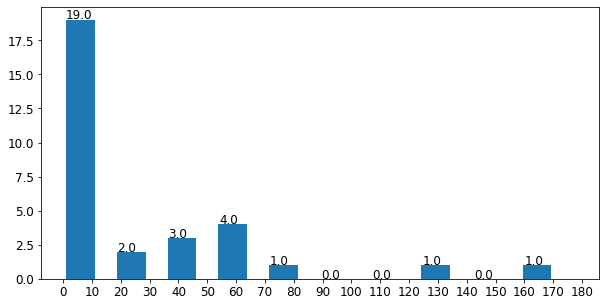

In [63]:
plt.subplots(figsize=(10, 5))
ax = wallets_grouped.rename(columns={"Address":"#Addresses in Wallet"})["#Addresses in Wallet"].hist(width = 10,align='mid')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xticks(np.arange(0, 200,10))
# plt.title("Histogram of Distribution of Vendor Wallet Sizes")
ax.grid(False)
plt.rcParams.update({'font.size': 8})
plt.plot()